In [ ]:
!unrar x /content/ImageCompression-TestSet.rar
!unrar x /content/ImageCompression-TrainSet.rar

### Autoencoder Training and Evaluation on Image Blocks

This section implements an image compression and reconstruction pipeline using a simple feedforward autoencoder. The code includes:

- Loading grayscale images from training and test folders (`TrainSet`, `TestSet`).
- Dividing each image into 8x8 non-overlapping blocks and normalizing them.
- Defining an autoencoder with one hidden layer and training it using backpropagation.
- Experimenting with different hidden layer sizes (`[4, 16, 32]`) to analyze reconstruction quality.
- Calculating reconstruction performance using the PSNR (Peak Signal-to-Noise Ratio) metric.
- Reconstructing the test images and visualizing both the original and reconstructed versions.
- Plotting the training loss across epochs for each hidden layer configuration.

The goal is to evaluate how the size of the hidden layer affects the quality of image reconstruction.



Training with hidden size: 4
Hidden Size 4 - Epoch 1/10, Loss: 0.6471987284265632
Hidden Size 4 - Epoch 2/10, Loss: 0.5526419830086631
Hidden Size 4 - Epoch 3/10, Loss: 0.5155179075746195
Hidden Size 4 - Epoch 4/10, Loss: 0.49832517451728076
Hidden Size 4 - Epoch 5/10, Loss: 0.49297515767933164
Hidden Size 4 - Epoch 6/10, Loss: 0.48963157634475934
Hidden Size 4 - Epoch 7/10, Loss: 0.48699511506167154
Hidden Size 4 - Epoch 8/10, Loss: 0.48532227799796096
Hidden Size 4 - Epoch 9/10, Loss: 0.4844756871496625
Hidden Size 4 - Epoch 10/10, Loss: 0.48432931225792336
Average PSNR for hidden size 4: 29.70 dB


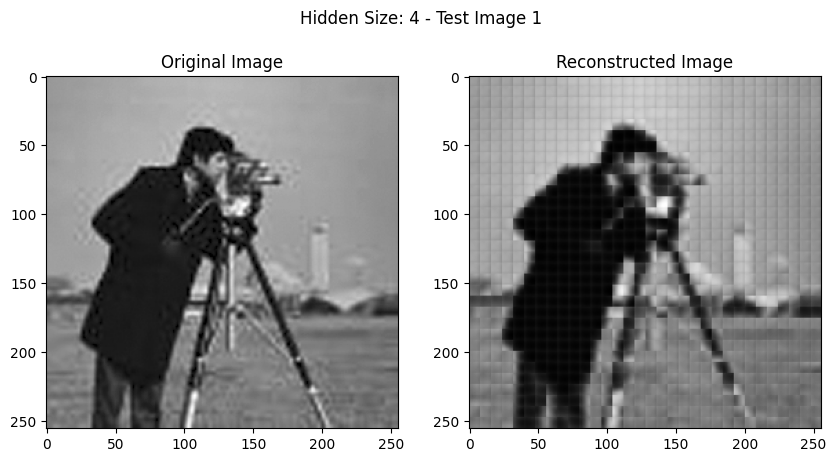

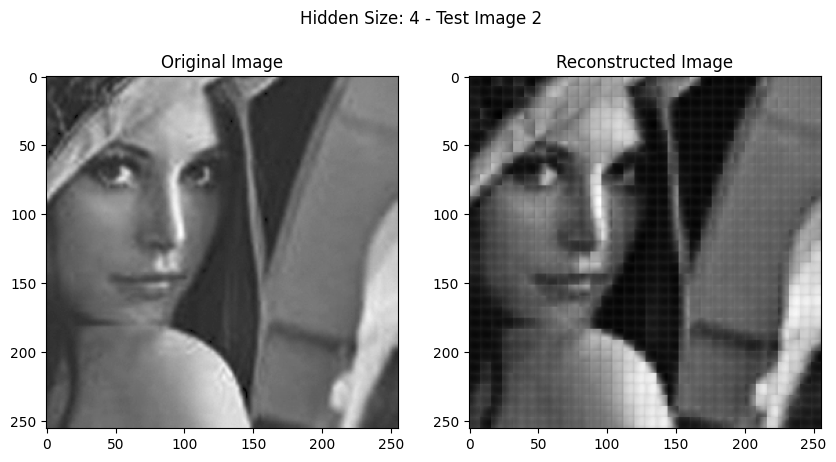

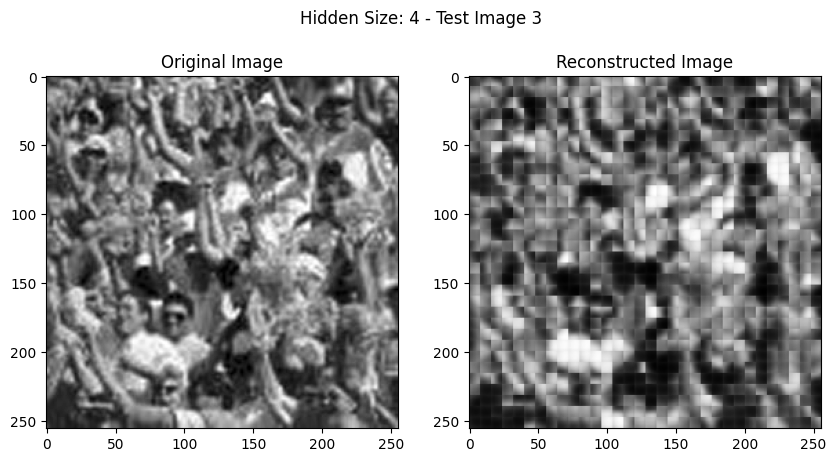

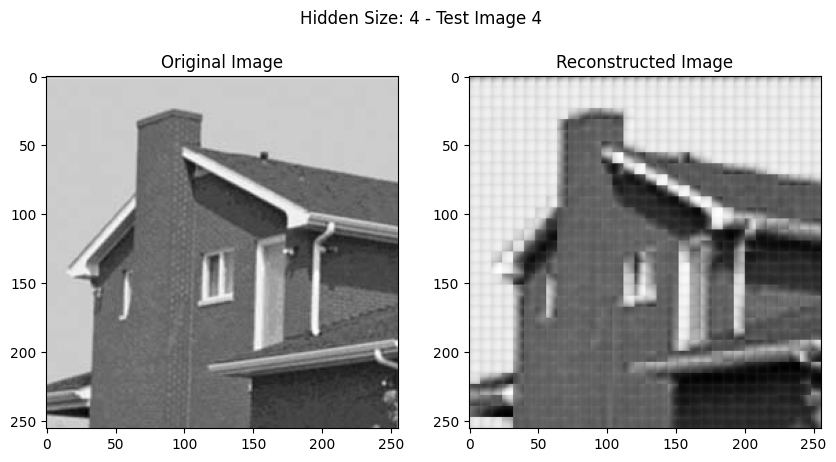

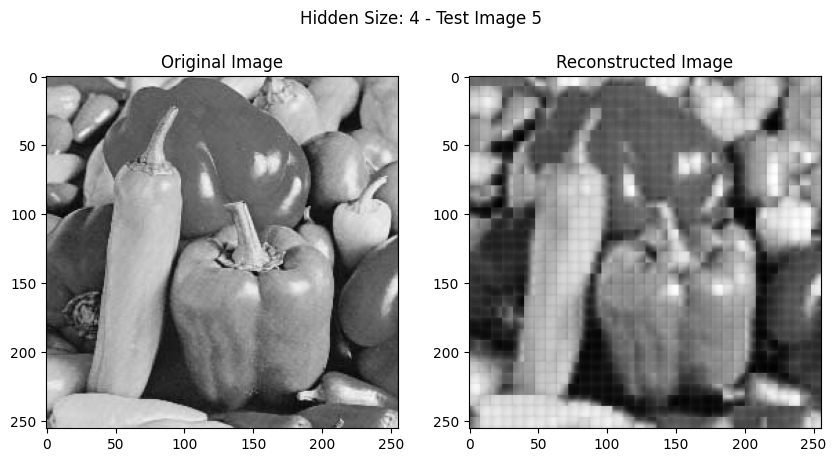


Training with hidden size: 16
Hidden Size 16 - Epoch 1/10, Loss: 0.34777848540140427
Hidden Size 16 - Epoch 2/10, Loss: 0.2078540102175215
Hidden Size 16 - Epoch 3/10, Loss: 0.19768953184863608
Hidden Size 16 - Epoch 4/10, Loss: 0.1908059098075321
Hidden Size 16 - Epoch 5/10, Loss: 0.1871575738507012
Hidden Size 16 - Epoch 6/10, Loss: 0.18479090547164775
Hidden Size 16 - Epoch 7/10, Loss: 0.18274987402709242
Hidden Size 16 - Epoch 8/10, Loss: 0.1791384398367379
Hidden Size 16 - Epoch 9/10, Loss: 0.17562926100159756
Hidden Size 16 - Epoch 10/10, Loss: 0.1737001473682264
Average PSNR for hidden size 16: 33.30 dB


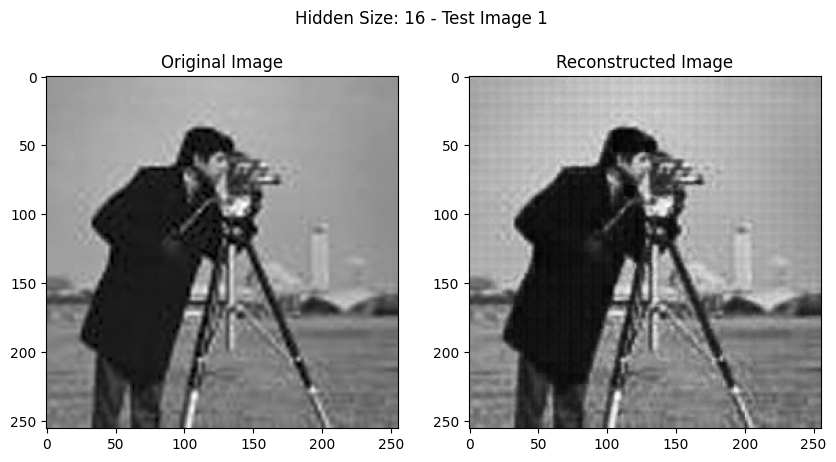

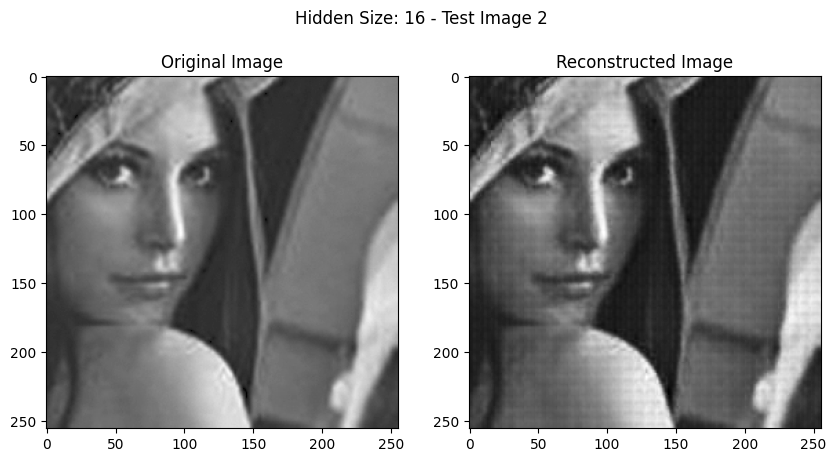

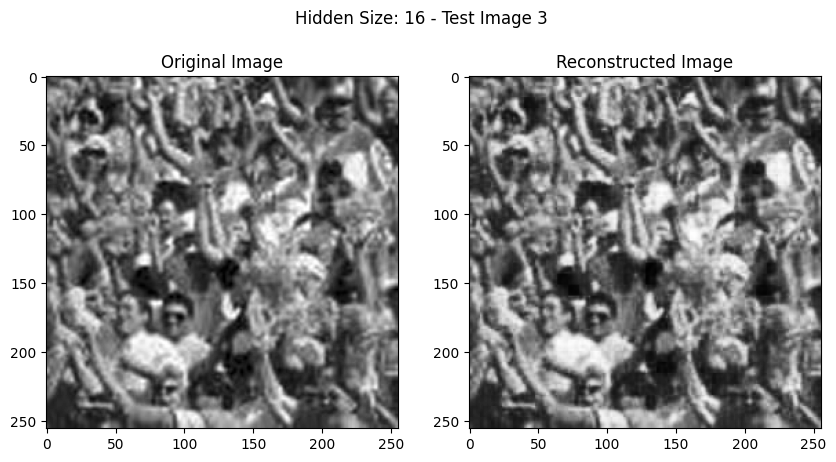

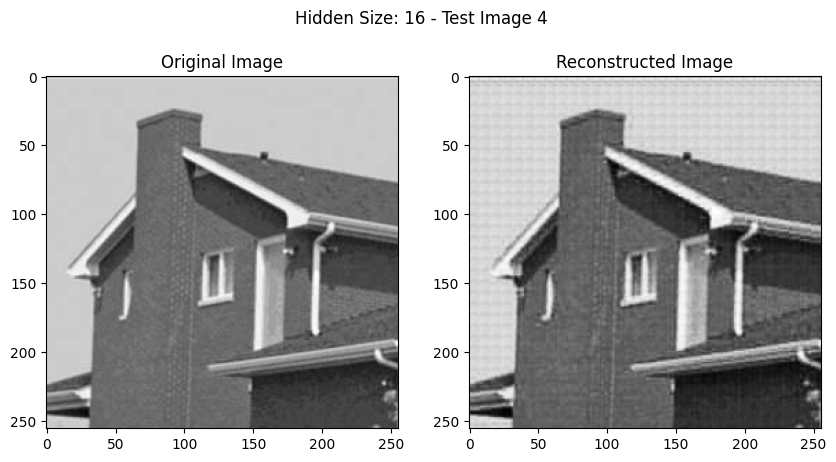

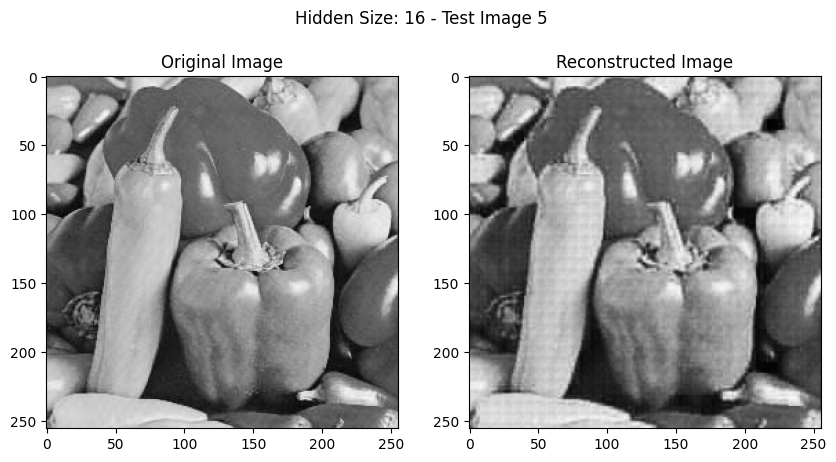


Training with hidden size: 32
Hidden Size 32 - Epoch 1/10, Loss: 0.271819823116791
Hidden Size 32 - Epoch 2/10, Loss: 0.13230192819011127
Hidden Size 32 - Epoch 3/10, Loss: 0.10845971516589711
Hidden Size 32 - Epoch 4/10, Loss: 0.09866173442039851
Hidden Size 32 - Epoch 5/10, Loss: 0.09433205319841813
Hidden Size 32 - Epoch 6/10, Loss: 0.09201494057306188
Hidden Size 32 - Epoch 7/10, Loss: 0.09045089157674661
Hidden Size 32 - Epoch 8/10, Loss: 0.08925998777415628
Hidden Size 32 - Epoch 9/10, Loss: 0.08830142110220753
Hidden Size 32 - Epoch 10/10, Loss: 0.0875087710953007
Average PSNR for hidden size 32: 36.40 dB


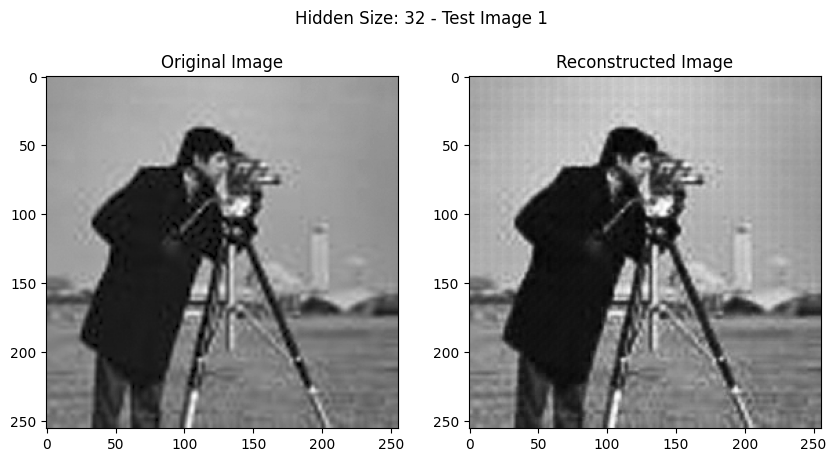

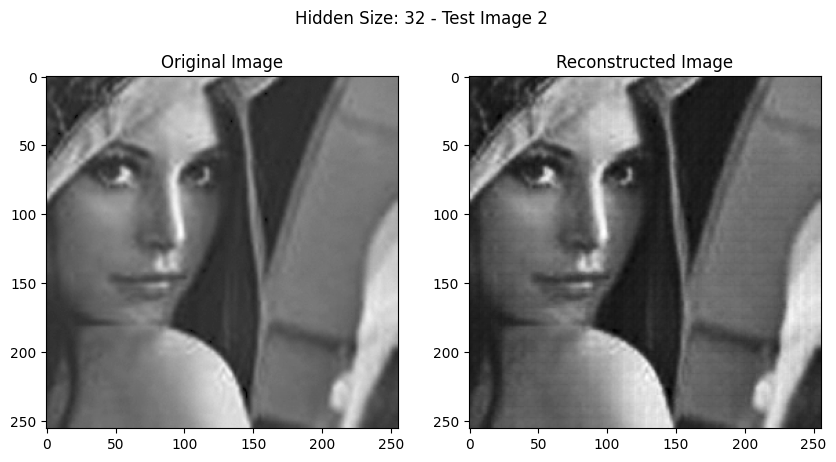

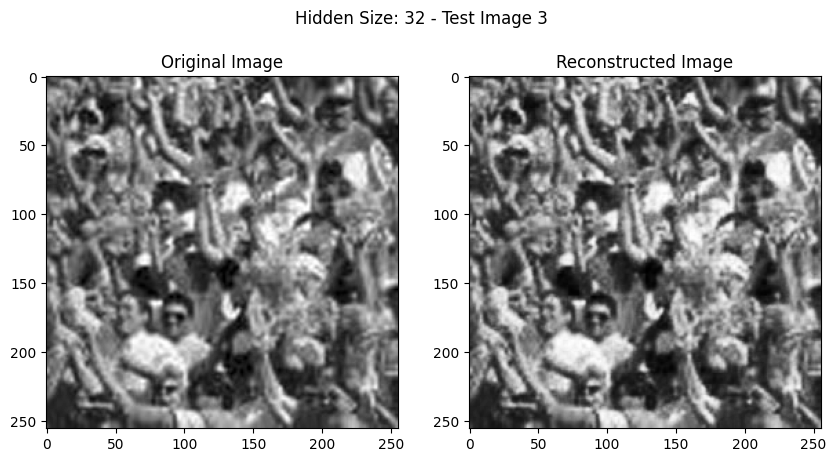

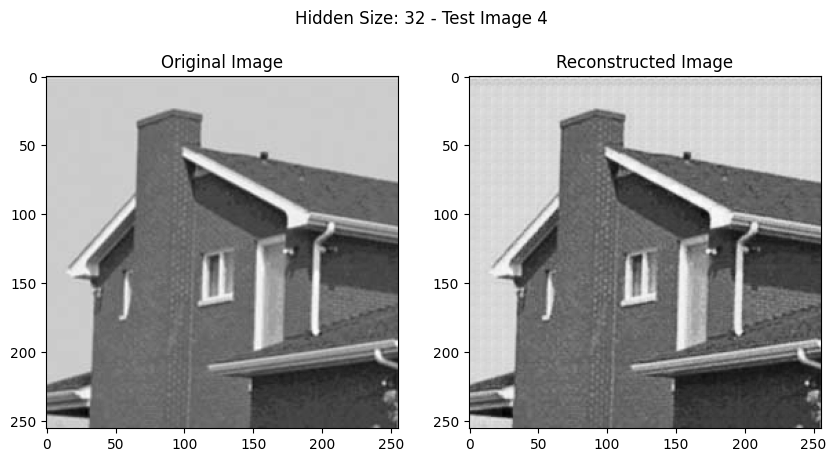

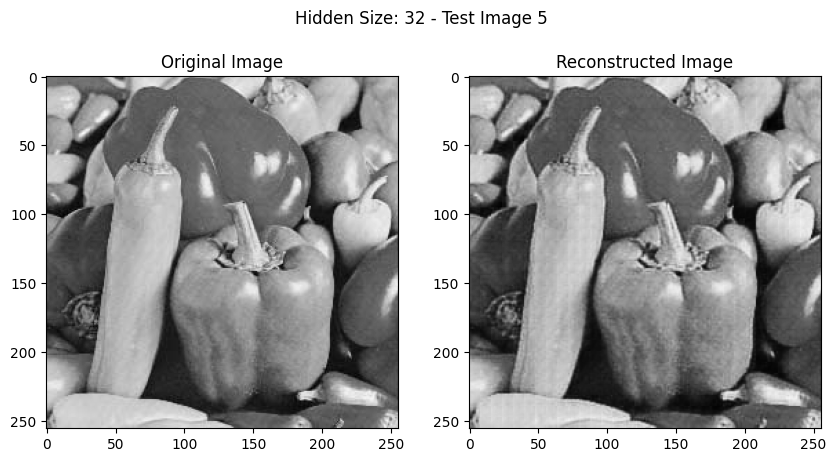

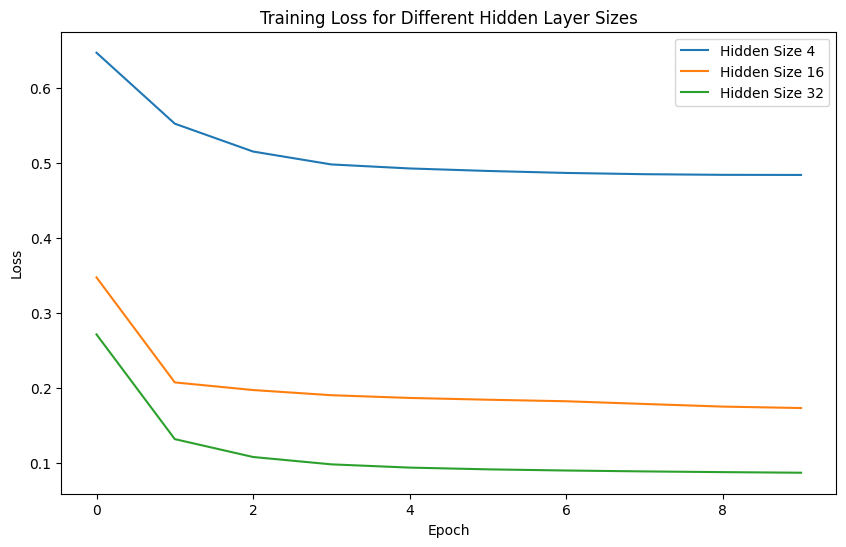

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# تابع برای بارگذاری تصاویر و تبدیل به بلوک‌های ۸x۸
def load_images_to_blocks(folder_path, block_size=8):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

# تبدیل تصویر به بلوک‌های 8x8
def image_to_blocks(img, block_size=8):
    blocks = []
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            block = img[i:i+block_size, j:j+block_size]
            blocks.append(block.flatten())
    return np.array(blocks) / 255.0  # نرمال‌سازی به محدوده 0 تا 1

# بازسازی تصویر از بلوک‌های 8x8
def blocks_to_image(blocks, img_shape, block_size=8):
    reconstructed_image = np.zeros(img_shape)
    idx = 0
    for i in range(0, img_shape[0], block_size):
        for j in range(0, img_shape[1], block_size):
            reconstructed_image[i:i+block_size, j:j+block_size] = blocks[idx].reshape(block_size, block_size)
            idx += 1
    return (reconstructed_image * 255).astype(np.uint8)  # تبدیل به مقیاس پیکسلی 0 تا 255

# تابع فعال‌سازی Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# مشتق تابع Sigmoid
def sigmoid_derivative(x):
    return x * (1 - x)

# تابع برای محاسبه PSNR
def calculate_psnr(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    if mse == 0:
        return float('inf')
    pixel_max = 255.0  # چون تصاویر به مقیاس 0 تا 255 بازگردانده می‌شوند
    return 20 * np.log10(pixel_max / np.sqrt(mse))

# تابع برای آموزش شبکه
def train_network(train_data, hidden_size, epochs=10, learning_rate=0.1):
    input_size = 64
    output_size = 64

    # مقداردهی اولیه وزن‌ها
    np.random.seed(0)
    W1 = np.random.randn(input_size, hidden_size) * 0.1
    W2 = np.random.randn(hidden_size, output_size) * 0.1
    b1 = np.zeros((hidden_size, 1))
    b2 = np.zeros((output_size, 1))

    loss_history = []  # برای ذخیره خطا در هر اپوک

    for epoch in range(epochs):
        total_loss = 0
        for x in train_data:
            # مرحله Forward
            x = x.reshape(-1, 1)
            h = sigmoid(np.dot(W1.T, x) + b1)  # فشرده‌سازی
            x_hat = sigmoid(np.dot(W2.T, h) + b2)  # بازفشرده‌سازی

            # محاسبه خطا
            error = x - x_hat
            total_loss += np.sum(error ** 2)

            # مرحله Backward (محاسبه گرادیان‌ها و به‌روزرسانی وزن‌ها)
            d_x_hat = error * sigmoid_derivative(x_hat)
            d_W2 = np.dot(h, d_x_hat.T)
            d_b2 = d_x_hat

            d_h = np.dot(W2, d_x_hat) * sigmoid_derivative(h)
            d_W1 = np.dot(x, d_h.T)
            d_b1 = d_h

            # به‌روزرسانی وزن‌ها و بایاس‌ها
            W1 += learning_rate * d_W1
            W2 += learning_rate * d_W2
            b1 += learning_rate * d_b1
            b2 += learning_rate * d_b2

        # ذخیره خطا در هر اپوک
        avg_loss = total_loss / len(train_data)
        loss_history.append(avg_loss)
        print(f"Hidden Size {hidden_size} - Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

    return W1, W2, b1, b2, loss_history

# آزمون شبکه روی داده‌های تست
def test_network(test_images, W1, W2, b1, b2):
    total_psnr = 0
    reconstructed_images = []
    for img in test_images:
        blocks = image_to_blocks(img)  # تبدیل تصویر به بلوک‌های 8x8
        reconstructed_blocks = []

        for x in blocks:
            x = x.reshape(-1, 1)
            h = sigmoid(np.dot(W1.T, x) + b1)
            x_hat = sigmoid(np.dot(W2.T, h) + b2).flatten()
            reconstructed_blocks.append(x_hat)

        # بازسازی تصویر کامل از بلوک‌های بازسازی‌شده
        reconstructed_img = blocks_to_image(reconstructed_blocks, img.shape)
        reconstructed_images.append(reconstructed_img)

        # محاسبه PSNR برای تصویر کامل
        psnr = calculate_psnr(img, reconstructed_img)
        total_psnr += psnr

    avg_psnr = total_psnr / len(test_images)
    return avg_psnr, reconstructed_images

# بارگذاری داده‌های آموزشی و آزمایشی
train_images = load_images_to_blocks('TrainSet')
test_images = load_images_to_blocks('TestSet')

# تبدیل همه تصاویر آموزشی به بلوک‌ها برای آموزش
train_blocks = []
for img in train_images:
    train_blocks.extend(image_to_blocks(img))

# آزمایش شبکه برای تعداد نرون‌های مخفی مختلف و رسم نمودار خطا
hidden_sizes = [4, 16, 32]
psnr_results = []
loss_histories = []

for hidden_size in hidden_sizes:
    print(f"\nTraining with hidden size: {hidden_size}")
    W1, W2, b1, b2, loss_history = train_network(train_blocks, hidden_size, epochs=10, learning_rate=0.1)
    avg_psnr, reconstructed_images = test_network(test_images, W1, W2, b1, b2)

    psnr_results.append(avg_psnr)
    loss_histories.append(loss_history)

    print(f"Average PSNR for hidden size {hidden_size}: {avg_psnr:.2f} dB")

    # نمایش تصاویر اصلی و بازسازی‌شده
    for i, (original_image, reconstructed_image) in enumerate(zip(test_images, reconstructed_images)):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.title("Reconstructed Image")
        plt.imshow(reconstructed_image, cmap='gray')
        plt.suptitle(f"Hidden Size: {hidden_size} - Test Image {i+1}")
        plt.show()

# رسم نمودار خطا برای هر تعداد نرون
plt.figure(figsize=(10, 6))
for i, hidden_size in enumerate(hidden_sizes):
    plt.plot(loss_histories[i], label=f"Hidden Size {hidden_size}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Hidden Layer Sizes")
plt.legend()
plt.show()

### Image Compression Using Autoencoder: Standard vs. Momentum-based Training

This section implements a full pipeline for training and evaluating an autoencoder model for grayscale image compression and reconstruction using two training strategies:

- **Standard Backpropagation**
- **Backpropagation with Momentum**

The major steps include:

- **Image Preprocessing**:  
  Images from `TrainSet` and `TestSet` directories are loaded and divided into non-overlapping 8x8 grayscale blocks. Each block is flattened and normalized.

- **Autoencoder Model**:  
  A basic fully-connected autoencoder with one hidden layer is used. The encoder compresses 64-dimensional image blocks into a smaller latent space (e.g., 16 units), and the decoder reconstructs them back.

- **Training Functions**:  
  Two training strategies are implemented:
  - `train_network_std`: Standard backpropagation.
  - `train_network_momentum`: Backpropagation with momentum (γ = 0.9).

- **Evaluation**:
  - The trained networks are used to reconstruct test images block by block.
  - Reconstructed images are evaluated using **PSNR (Peak Signal-to-Noise Ratio)**.
  - Average PSNR and training time are printed for both methods.

- **Visualization**:
  - Side-by-side display of original, standard-reconstructed, and momentum-reconstructed test images.
  - Loss curves over training epochs for both methods.

The goal is to compare the reconstruction quality and training efficiency of the standard and momentum-based learning strategies for autoencoder networks on small grayscale image patches.



Training with Standard Method:
Standard Method - Epoch 1/10, Loss: 2.3765696224736907
Standard Method - Epoch 2/10, Loss: 0.9917684755384568
Standard Method - Epoch 3/10, Loss: 0.8888739407140508
Standard Method - Epoch 4/10, Loss: 0.7755911376802167
Standard Method - Epoch 5/10, Loss: 0.656323335939365
Standard Method - Epoch 6/10, Loss: 0.5732099386484211
Standard Method - Epoch 7/10, Loss: 0.5297209159918096
Standard Method - Epoch 8/10, Loss: 0.5071128357258985
Standard Method - Epoch 9/10, Loss: 0.49184845543693767
Standard Method - Epoch 10/10, Loss: 0.47852080599434327
Average PSNR for Standard Method: 30.47 dB
Training Time for Standard Method: 52.96 seconds

Training with Momentum Method:
Momentum Method - Epoch 1/10, Loss: 0.8350793267353608
Momentum Method - Epoch 2/10, Loss: 0.4024775999054565
Momentum Method - Epoch 3/10, Loss: 0.3232594127063207
Momentum Method - Epoch 4/10, Loss: 0.28510323585672187
Momentum Method - Epoch 5/10, Loss: 0.26222697661162325
Momentum Method

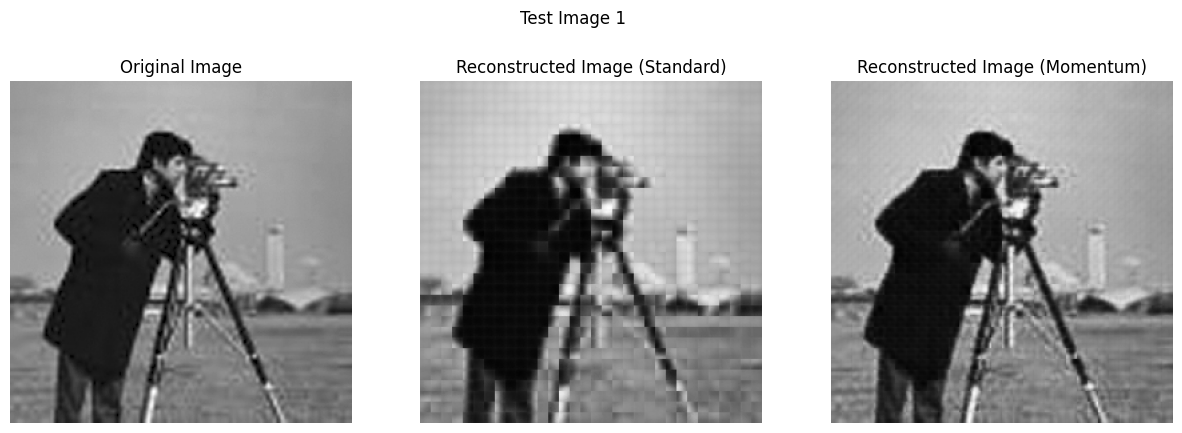

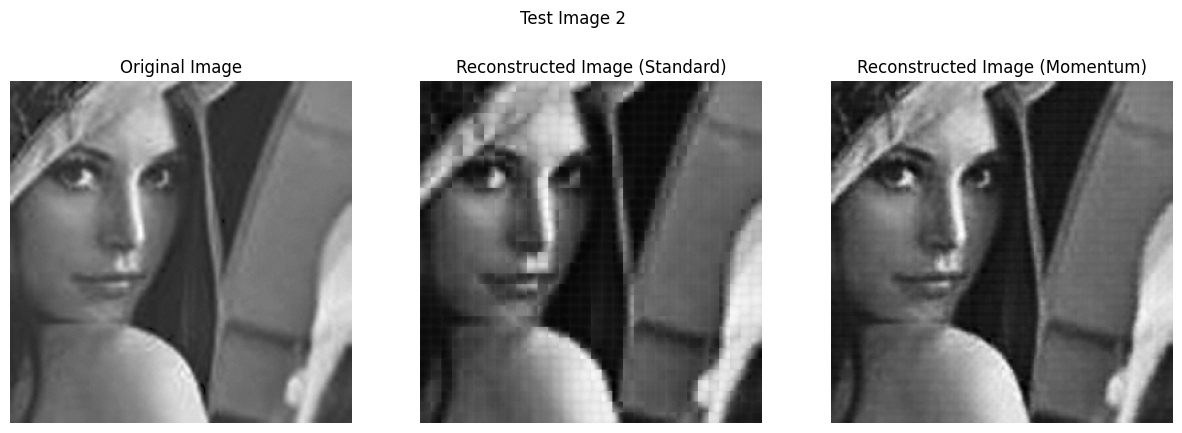

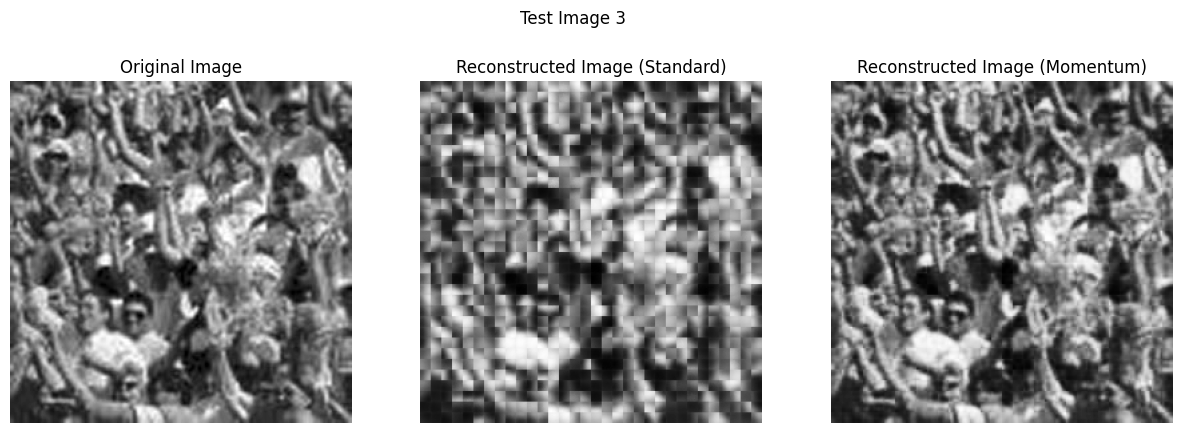

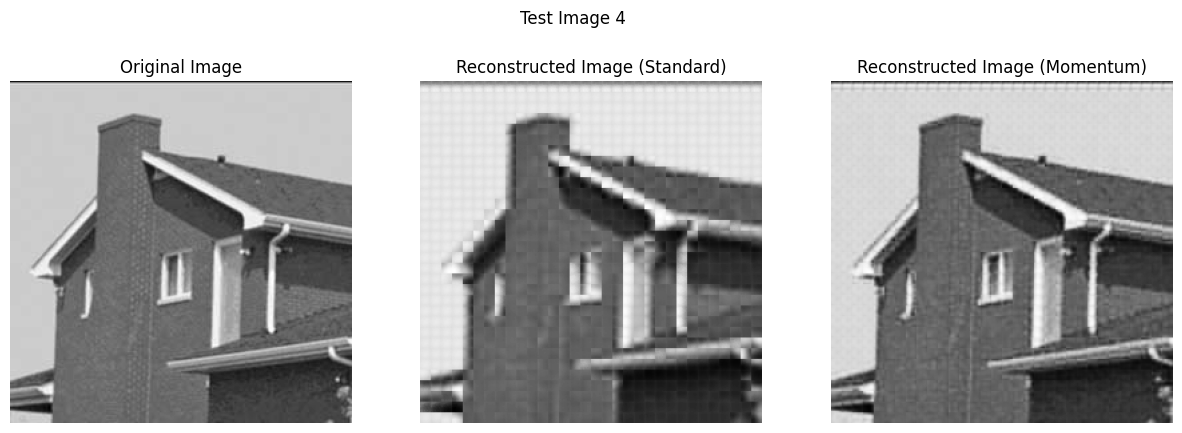

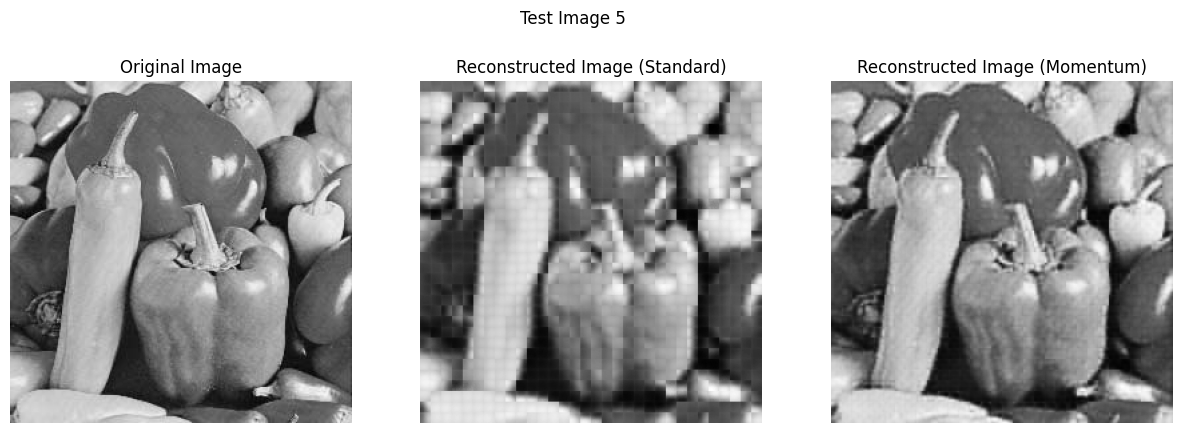

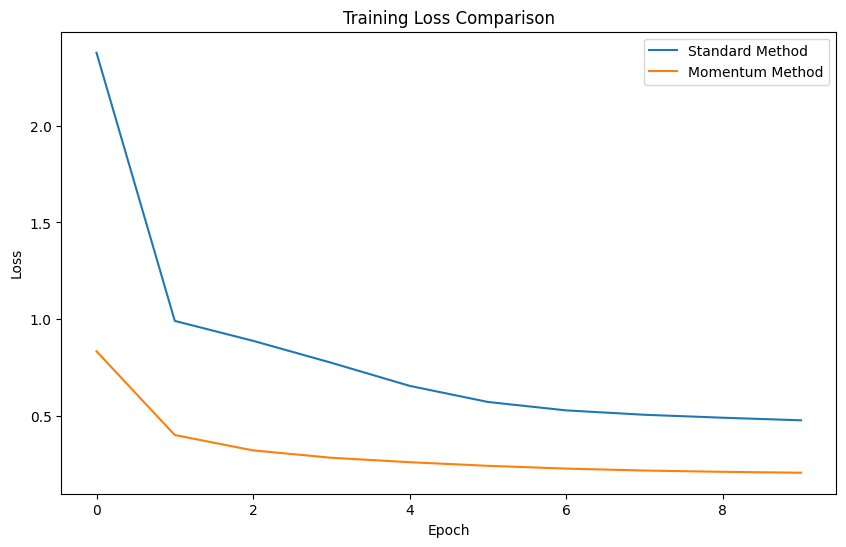

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

# تابع برای بارگذاری تصاویر و تبدیل به بلوک‌های ۸x۸
def load_images_to_blocks(folder_path, block_size=8):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append(img)
    return images

# تبدیل تصویر به بلوک‌های 8x8
def image_to_blocks(img, block_size=8):
    blocks = []
    for i in range(0, img.shape[0], block_size):
        for j in range(0, img.shape[1], block_size):
            block = img[i:i+block_size, j:j+block_size]
            blocks.append(block.flatten())
    return np.array(blocks) / 255.0  # نرمال‌سازی به محدوده 0 تا 1

# بازسازی تصویر از بلوک‌های 8x8
def blocks_to_image(blocks, img_shape, block_size=8):
    reconstructed_image = np.zeros(img_shape)
    idx = 0
    for i in range(0, img_shape[0], block_size):
        for j in range(0, img_shape[1], block_size):
            reconstructed_image[i:i+block_size, j:j+block_size] = blocks[idx].reshape(block_size, block_size)
            idx += 1
    return (reconstructed_image * 255).astype(np.uint8)  # تبدیل به مقیاس پیکسلی 0 تا 255

# تابع فعال‌سازی Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# مشتق تابع Sigmoid
def sigmoid_derivative(x):
    return x * (1 - x)

# تابع برای محاسبه PSNR
def calculate_psnr(original, reconstructed):
    mse = mean_squared_error(original, reconstructed)
    if mse == 0:
        return float('inf')
    pixel_max = 255.0  # چون تصاویر به مقیاس 0 تا 255 بازگردانده می‌شوند
    return 20 * np.log10(pixel_max / np.sqrt(mse))

# تابع برای آموزش شبکه با روش استاندارد
def train_network_std(train_data, hidden_size, epochs=10, learning_rate=0.1):
    input_size = 64
    output_size = 64

    # مقداردهی اولیه وزن‌ها
    np.random.seed(0)
    W1 = np.random.randn(input_size, hidden_size) * 0.1
    W2 = np.random.randn(hidden_size, output_size) * 0.1
    b1 = np.zeros((hidden_size, 1))
    b2 = np.zeros((output_size, 1))

    loss_history = []  # برای ذخیره خطا در هر اپوک

    for epoch in range(epochs):
        total_loss = 0
        for x in train_data:
            # مرحله Forward
            x = x.reshape(-1, 1)
            h = sigmoid(np.dot(W1.T, x) + b1)  # فشرده‌سازی
            x_hat = sigmoid(np.dot(W2.T, h) + b2)  # بازفشرده‌سازی

            # محاسبه خطا
            error = x - x_hat
            total_loss += np.sum(error ** 2)

            # مرحله Backward (محاسبه گرادیان‌ها و به‌روزرسانی وزن‌ها)
            d_x_hat = error * sigmoid_derivative(x_hat)
            d_W2 = np.dot(h, d_x_hat.T)
            d_b2 = d_x_hat

            d_h = np.dot(W2, d_x_hat) * sigmoid_derivative(h)
            d_W1 = np.dot(x, d_h.T)
            d_b1 = d_h

            # به‌روزرسانی وزن‌ها و بایاس‌ها
            W1 += learning_rate * d_W1
            W2 += learning_rate * d_W2
            b1 += learning_rate * d_b1
            b2 += learning_rate * d_b2

        # ذخیره خطا در هر اپوک
        avg_loss = total_loss / len(train_data)
        loss_history.append(avg_loss)
        print(f"Standard Method - Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

    return W1, W2, b1, b2, loss_history

# تابع برای آموزش شبکه با روش گشتاور
def train_network_momentum(train_data, hidden_size, epochs=10, learning_rate=0.1, momentum=0.9):
    input_size = 64
    output_size = 64

    # مقداردهی اولیه وزن‌ها
    np.random.seed(0)
    W1 = np.random.randn(input_size, hidden_size) * 0.1
    W2 = np.random.randn(hidden_size, output_size) * 0.1
    b1 = np.zeros((hidden_size, 1))
    b2 = np.zeros((output_size, 1))

    # مقداردهی اولیه ممان‌ها
    v_W1 = np.zeros_like(W1)
    v_W2 = np.zeros_like(W2)
    v_b1 = np.zeros_like(b1)
    v_b2 = np.zeros_like(b2)

    loss_history = []  # برای ذخیره خطا در هر اپوک

    for epoch in range(epochs):
        total_loss = 0
        for x in train_data:
            # مرحله Forward
            x = x.reshape(-1, 1)
            h = sigmoid(np.dot(W1.T, x) + b1)  # فشرده‌سازی
            x_hat = sigmoid(np.dot(W2.T, h) + b2)  # بازفشرده‌سازی

            # محاسبه خطا
            error = x - x_hat
            total_loss += np.sum(error ** 2)

            # مرحله Backward (محاسبه گرادیان‌ها و به‌روزرسانی وزن‌ها)
            d_x_hat = error * sigmoid_derivative(x_hat)
            d_W2 = np.dot(h, d_x_hat.T)
            d_b2 = d_x_hat

            d_h = np.dot(W2, d_x_hat) * sigmoid_derivative(h)
            d_W1 = np.dot(x, d_h.T)
            d_b1 = d_h

            # به‌روزرسانی ممان‌ها
            v_W1 = momentum * v_W1 + learning_rate * d_W1
            v_W2 = momentum * v_W2 + learning_rate * d_W2
            v_b1 = momentum * v_b1 + learning_rate * d_b1
            v_b2 = momentum * v_b2 + learning_rate * d_b2

            # به‌روزرسانی وزن‌ها و بایاس‌ها
            W1 += v_W1
            W2 += v_W2
            b1 += v_b1
            b2 += v_b2

        # ذخیره خطا در هر اپوک
        avg_loss = total_loss / len(train_data)
        loss_history.append(avg_loss)
        print(f"Momentum Method - Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

    return W1, W2, b1, b2, loss_history

# آزمون شبکه روی داده‌های تست
def test_network(test_images, W1, W2, b1, b2):
    total_psnr = 0
    reconstructed_images = []
    for img in test_images:
        blocks = image_to_blocks(img)  # تبدیل تصویر به بلوک‌های 8x8
        reconstructed_blocks = []

        for x in blocks:
            x = x.reshape(-1, 1)
            h = sigmoid(np.dot(W1.T, x) + b1)
            x_hat = sigmoid(np.dot(W2.T, h) + b2).flatten()
            reconstructed_blocks.append(x_hat)

        # بازسازی تصویر کامل از بلوک‌های بازسازی‌شده
        reconstructed_img = blocks_to_image(reconstructed_blocks, img.shape)
        reconstructed_images.append(reconstructed_img)

        # محاسبه PSNR برای تصویر کامل
        psnr = calculate_psnr(img, reconstructed_img)
        total_psnr += psnr

    avg_psnr = total_psnr / len(test_images)
    return avg_psnr, reconstructed_images

# بارگذاری داده‌های آموزشی و آزمایشی
train_images = load_images_to_blocks('TrainSet')
test_images = load_images_to_blocks('TestSet')

# تبدیل همه تصاویر آموزشی به بلوک‌ها برای آموزش
train_blocks = []
for img in train_images:
    train_blocks.extend(image_to_blocks(img))

# آموزش با روش استاندارد
print("\nTraining with Standard Method:")
start_time_std = time.time()
W1_std, W2_std, b1_std, b2_std, loss_history_std = train_network_std(train_blocks, hidden_size=16, epochs=10, learning_rate=0.001)
end_time_std = time.time()
avg_psnr_std, reconstructed_images_std = test_network(test_images, W1_std, W2_std, b1_std, b2_std)
print(f"Average PSNR for Standard Method: {avg_psnr_std:.2f} dB")
print(f"Training Time for Standard Method: {(end_time_std - start_time_std):.2f} seconds")

# آموزش با روش گشتاور
print("\nTraining with Momentum Method:")
start_time_mom = time.time()
W1_mom, W2_mom, b1_mom, b2_mom, loss_history_mom = train_network_momentum(train_blocks, hidden_size=16, epochs=10, learning_rate=0.001, momentum=0.9)
end_time_mom = time.time()
avg_psnr_mom, reconstructed_images_mom = test_network(test_images, W1_mom, W2_mom, b1_mom, b2_mom)
print(f"Average PSNR for Momentum Method: {avg_psnr_mom:.2f} dB")
print(f"Training Time for Momentum Method: {(end_time_mom - start_time_mom):.2f} seconds")

# نمایش تصاویر اصلی و بازسازی‌شده برای هر دو روش (استاندارد و گشتاور)
for i, original_image in enumerate(test_images):
    plt.figure(figsize=(15, 5))

    # نمایش تصویر اصلی
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    # نمایش تصویر بازسازی‌شده با روش استاندارد
    plt.subplot(1, 3, 2)
    plt.title("Reconstructed Image (Standard)")
    plt.imshow(reconstructed_images_std[i], cmap='gray')
    plt.axis('off')

    # نمایش تصویر بازسازی‌شده با گشتاور
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed Image (Momentum)")
    plt.imshow(reconstructed_images_mom[i], cmap='gray')
    plt.axis('off')

    plt.suptitle(f"Test Image {i + 1}")
    plt.show()

# رسم نمودار خطا برای هر دو روش
plt.figure(figsize=(10, 6))
plt.plot(loss_history_std, label="Standard Method")
plt.plot(loss_history_mom, label="Momentum Method")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()


### Section 2: Training and Evaluating a Custom Autoencoder on the MNIST Dataset

In this section, we implement a simple feedforward autoencoder from scratch using NumPy to compress and reconstruct MNIST digit images. The code defines an `Autoencoder` class that supports different activation functions (`sigmoid`, `relu`, and `tanh`), and includes training with backpropagation and early stopping based on validation loss.

We first load and preprocess the MNIST dataset by flattening and normalizing the pixel values. Then, we define a specific autoencoder architecture (e.g., `[784, 64, 784]`), initialize it, and train it using the `train_with_validation` function. This function trains the autoencoder, plots training and validation loss over epochs, and visually compares original versus reconstructed images.

The final MSE on the test set is returned for further analysis.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# تابع برای محاسبه MSE
def calculate_mse(original, reconstructed):
    return np.mean((original - reconstructed) ** 2)

# توابع فعال‌سازی
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

# کلاس Autoencoder
class Autoencoder:
    def __init__(self, layers, activation_function='sigmoid', learning_rate=0.001, epochs=10, batch_size=1, patience=2):
        self.layers = layers
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience

        # وزن‌ها و بایاس‌ها
        self.weights = []
        self.biases = []
        for i in range(len(layers) - 1):
            w = np.random.randn(layers[i], layers[i + 1]) * 0.1
            b = np.zeros((layers[i + 1], 1))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, x):
        self.a = [x]
        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i].T
            if self.activation_function == 'sigmoid':
                a = sigmoid(z)
            elif self.activation_function == 'relu':
                a = relu(z)
            elif self.activation_function == 'tanh':
                a = tanh(z)
            self.a.append(a)
        return self.a[-1]

    def backward(self, x):
        m = x.shape[0]
        dz = self.a[-1] - x
        loss = calculate_mse(x, self.a[-1])  # محاسبه خطا
        for i in reversed(range(len(self.weights))):
            if self.activation_function == 'sigmoid':
                derivative = sigmoid_derivative(self.a[i + 1])
            elif self.activation_function == 'relu':
                derivative = relu_derivative(self.a[i + 1])
            elif self.activation_function == 'tanh':
                derivative = tanh_derivative(self.a[i + 1])

            dz = dz * derivative  # اعمال مشتق
            dw = np.dot(self.a[i].T, dz) / m  # محاسبه گرادیان وزن‌ها
            db = np.sum(dz, axis=0, keepdims=True) / m  # محاسبه گرادیان بایاس‌ها

            # به‌روزرسانی وزن‌ها و بایاس‌ها
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db.T

            dz = np.dot(dz, self.weights[i].T)  # تنظیم dz برای لایه قبلی

        return loss

    def train(self, x_train, x_val):
        val_losses = []
        train_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            epoch_loss = 0
            for i in range(0, x_train.shape[0], self.batch_size):
                x_batch = x_train[i:i + self.batch_size]
                self.forward(x_batch)
                loss = self.backward(x_batch)
                epoch_loss += loss

            # میانگین خطای آموزش
            train_loss = epoch_loss / (x_train.shape[0] // self.batch_size)
            train_losses.append(train_loss)

            # محاسبه MSE برای داده‌های validation
            val_loss = self.forward(x_val)
            val_loss = calculate_mse(x_val, self.a[-1])
            val_losses.append(val_loss)

            print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

            # بررسی Early Stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0  # Reset the counter if we see improvement
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print("Early stopping activated!")
                break  # Stop training if no improvement

        return train_losses, val_losses

    def reconstruct(self, x):
        return self.forward(x)

# بارگذاری داده‌های MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

# جدا کردن داده‌های آموزش به عنوان validation با stratify
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

# تعریف لایه‌ها و پارامترها
layers = [784, 64, 784]
activation_function = 'sigmoid'
learning_rate = 0.001
epochs = 10
batch_size = 1

def train_with_validation(layers, activation_function='sigmoid', learning_rate=0.001, epochs=10, batch_size=1, patience=2):
    # ایجاد مدل
    autoencoder = Autoencoder(layers, activation_function=activation_function, learning_rate=learning_rate, epochs=epochs, batch_size=batch_size, patience=patience)

    # آموزش مدل
    train_loss, val_loss = autoencoder.train(x_train, x_val)

    # ارزیابی بر روی داده‌های آزمون
    reconstructed_images = autoencoder.reconstruct(x_test)
    mse = calculate_mse(x_test, reconstructed_images)

    # رسم نمودار MSE برای داده‌های آموزشی و اعتبارسنجی
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'MSE Loss for Layers: {layers}')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

    # نمایش تصاویری از داده‌های آزمون و تصاویر بازسازی شده
    plt.figure(figsize=(10, 5))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.suptitle(f"Layers: {layers}")
    plt.show()

    return mse  # برگرداندن مقدار MSE برای استفاده در تحلیل‌ها


### Training a Basic Autoencoder and Visualizing Reconstructed Images

This section builds and trains a simple fully connected autoencoder from scratch using NumPy to compress and reconstruct MNIST images. The `Autoencoder` class supports two activation functions (`sigmoid` and `tanh`) and is trained using mini-batch gradient descent.

The MNIST dataset is loaded and preprocessed by flattening and normalizing the pixel values. We define a three-layer autoencoder (`[784, 128, 784]`) and train it on the training data while monitoring validation loss. Once trained, the autoencoder's bottleneck layer (latent representation) is extracted for both training and test sets.

Finally, we visualize a few reconstructed images from the test set compared to the original images to qualitatively assess the autoencoder’s performance.


Epoch 1/50, Training Loss: 0.0210, Validation Loss: 0.0106
Epoch 2/50, Training Loss: 0.0085, Validation Loss: 0.0073
Epoch 3/50, Training Loss: 0.0066, Validation Loss: 0.0063
Epoch 4/50, Training Loss: 0.0057, Validation Loss: 0.0056
Epoch 5/50, Training Loss: 0.0052, Validation Loss: 0.0053
Epoch 6/50, Training Loss: 0.0048, Validation Loss: 0.0052
Epoch 7/50, Training Loss: 0.0046, Validation Loss: 0.0050
Epoch 8/50, Training Loss: 0.0044, Validation Loss: 0.0051
Epoch 9/50, Training Loss: 0.0042, Validation Loss: 0.0046
Epoch 10/50, Training Loss: 0.0041, Validation Loss: 0.0047
Epoch 11/50, Training Loss: 0.0040, Validation Loss: 0.0050
Epoch 12/50, Training Loss: 0.0039, Validation Loss: 0.0051
Epoch 13/50, Training Loss: 0.0038, Validation Loss: 0.0042
Epoch 14/50, Training Loss: 0.0038, Validation Loss: 0.0047
Epoch 15/50, Training Loss: 0.0037, Validation Loss: 0.0047
Epoch 16/50, Training Loss: 0.0037, Validation Loss: 0.0047
Epoch 17/50, Training Loss: 0.0036, Validation Lo

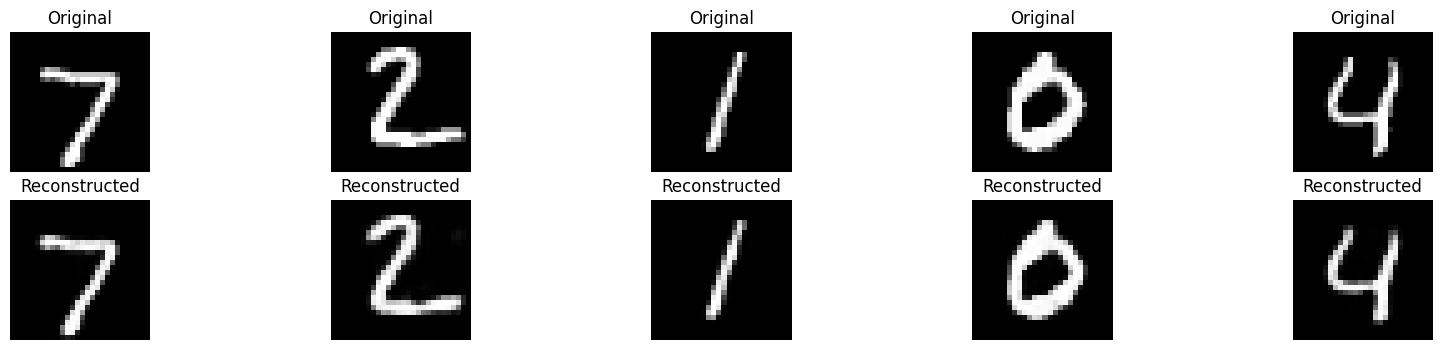

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

# توابع کمکی
def calculate_mse(original, reconstructed):
    return np.mean(np.square(original - reconstructed))

def calculate_accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

class Autoencoder:
    def __init__(self, layers, activation_function='sigmoid', learning_rate=0.01, epochs=100, batch_size=32):
        self.layers = layers
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = [np.random.randn(layers[i], layers[i + 1]) * 0.01 for i in range(len(layers) - 1)]
        self.biases = [np.zeros((1, layers[i + 1])) for i in range(len(layers) - 1)]

    def activate(self, x):
        if self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation_function == 'tanh':
            return np.tanh(x)
        return x

    def activate_derivative(self, x):
        if self.activation_function == 'sigmoid':
            return x * (1 - x)
        elif self.activation_function == 'tanh':
            return 1 - np.square(x)
        return x

    def forward(self, x):
        self.a = [x]
        for i in range(len(self.weights)):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            self.a.append(self.activate(z))
        return self.a[-1]  # خروجی لایه آخر

    def get_encoded(self, x):
        self.forward(x)
        return self.a[1]  # خروجی لایه میانی

    def backward(self, x):
        m = x.shape[0]
        dz = self.a[-1] - x  # Loss gradient
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.a[i].T, dz) / m
            db = np.sum(dz, axis=0, keepdims=True) / m
            dz = np.dot(dz, self.weights[i].T) * self.activate_derivative(self.a[i])  # Gradient
            self.weights[i] -= self.learning_rate * dw
            self.biases[i] -= self.learning_rate * db
        loss = calculate_mse(x, self.a[-1])
        return loss

    def train(self, x_train, x_val):
        val_losses = []
        train_losses = []
        for epoch in range(self.epochs):
            epoch_loss = 0
            for i in range(0, x_train.shape[0], self.batch_size):
                x_batch = x_train[i:i + self.batch_size]
                self.forward(x_batch)
                loss = self.backward(x_batch)
                epoch_loss += loss

            # Mean training loss
            train_loss = epoch_loss / (x_train.shape[0] // self.batch_size)
            train_losses.append(train_loss)

            # Calculate MSE for validation data
            val_loss = self.forward(x_val)
            val_loss = calculate_mse(x_val, self.a[-1])
            val_losses.append(val_loss)

            print(f'Epoch {epoch + 1}/{self.epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        return train_losses, val_losses

# بارگذاری داده‌ها
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255

# تقسیم داده‌ها به داده‌های validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train)

# One-hot encoding for labels
def encode_labels(y):
    return np.array([[1 if j == i else 0 for j in range(10)] for i in y])

y_train_encoded = encode_labels(y_train)
y_val_encoded = encode_labels(y_val)
y_test_encoded = encode_labels(y_test)

# آموزش Autoencoder
layers_autoencoder = [784, 128, 784]
autoencoder = Autoencoder(layers_autoencoder, activation_function='sigmoid', learning_rate=0.1, epochs=50, batch_size=32)
autoencoder.train(x_train, x_val)

# استخراج ویژگی‌ها
encoded_train_data = autoencoder.get_encoded(x_train)  # خروجی لایه میانی برای داده‌های آموزش
encoded_test_data = autoencoder.get_encoded(x_test)  # خروجی لایه میانی برای داده‌های تست

# نمایش تصاویر ورودی و خروجی
def plot_reconstructed_images(original, reconstructed, n=5):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # نمایش تصاویر اصلی
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # نمایش تصاویر بازسازی‌شده
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")

    plt.show()

# بازسازی تصاویر از Autoencoder
reconstructed_images = autoencoder.forward(x_test)

# نمایش تصاویر اصلی و بازسازی‌شده
plot_reconstructed_images(x_test, reconstructed_images)